In [1]:
! pip install -U datasets
! pip install -q fsspec==2023.9.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 24.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12

In [2]:
# prompt: load rockerritesh/maithiliNewsData dataset train

from datasets import load_dataset
dataset = load_dataset("rockerritesh/maithiliNewsData", split="train")

README.md:   0%|          | 0.00/463 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/12383 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3096 [00:00<?, ? examples/s]

In [3]:
import pandas as pd

# load devnagari data
df = dataset.to_pandas()

df.head()

,text,labels
0,शीतलं निर्मलं तोयं कर्पूरेण सुवासितम्। आचम्यता...,Culture
1,देश भरि मे मंदिर के संख्या कतेक अछि ई सवाल आर्...,Entertainment
2,सो काल-खण्डमा कलम चलाउने कारीगरहरुले मातृशक्ति...,Culture
3,सिनेमाक निर्माण करबाक अछि।काठमांडू के मोएक्स ह...,Entertainment
4,मंगलवार क॑ राजधानी डुप्लीकेट ईस्ट वेस्ट कॉन्टा...,EduTech


In [4]:
# Examine the dataset
print(f"Dataset shape: {df.shape}")
print(f"\nLabel distribution:")
print(df['labels'].value_counts())
print(f"\nBasic statistics:")
print(df.describe())


Dataset shape: (12383, 2)

Label distribution:
labels
Culture          2575
Literature       2212
Politics         2075
Sports           1774
Entertainment     844
Opinion           805
EduTech           619
Economy           549
Health            506
Interview         424
Name: count, dtype: int64

Basic statistics:
                                                     text   labels
count                                               12376    12383
unique                                              12077       10
top     ",,Δ,"मुकुन्द मयंक बर्ष 2012 या 2013 छल हेते, ...  Culture
freq                                                   27     2575


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import pickle
import os

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [6]:
# Data preprocessing
# Clean and prepare the text data
df = df.dropna(subset=['text', 'labels']).copy()
print(f"Dataset size after removing missing values: {df.shape[0]}")

Dataset size after removing missing values: 12376


# lstm+rnn

In [7]:
# Text preprocessing functions
def clean_text(text):
    """Clean and preprocess text"""
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    # Remove non-Devanagari characters except spaces
    text = re.sub(r'[^\u0900-\u097F\s]', '', text)
    return text.strip()

def create_vocabulary(texts, vocab_size=10000):
    """Create vocabulary from texts"""
    # Combine all characters
    all_chars = ''.join(texts)
    char_counts = Counter(all_chars)

    # Get most common characters
    most_common_chars = char_counts.most_common(vocab_size - 2)  # -2 for UNK and PAD

    # Create char to index mapping
    char_to_idx = {'<PAD>': 0, '<UNK>': 1}
    for char, _ in most_common_chars:
        if char not in char_to_idx:
            char_to_idx[char] = len(char_to_idx)

    idx_to_char = {idx: char for char, idx in char_to_idx.items()}

    return char_to_idx, idx_to_char

def encode_text(text, char_to_idx, max_length=512):
    """Encode text to sequence of indices"""
    encoded = []
    for char in text[:max_length]:
        if char in char_to_idx:
            encoded.append(char_to_idx[char])
        else:
            encoded.append(char_to_idx['<UNK>'])

    # Pad sequence
    if len(encoded) < max_length:
        encoded.extend([char_to_idx['<PAD>']] * (max_length - len(encoded)))

    return encoded

# Preprocess the data
print("Preprocessing data...")
df['text_clean'] = df['text'].apply(clean_text)

# Encode labels
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['labels'])

print(f"Number of classes: {len(label_encoder.classes_)}")
print(f"Classes: {label_encoder.classes_}")


Preprocessing data...
Number of classes: 10
Classes: ['Culture' 'Economy' 'EduTech' 'Entertainment' 'Health' 'Interview'
 'Literature' 'Opinion' 'Politics' 'Sports']


In [8]:
# Create vocabulary
char_to_idx, idx_to_char = create_vocabulary(df['text_clean'].tolist(), vocab_size=5000)
vocab_size = len(char_to_idx)

print(f"Vocabulary size: {vocab_size}")
print(f"Sample characters: {list(char_to_idx.keys())[:20]}")

# Encode texts
max_length = 512
df['text_encoded'] = df['text_clean'].apply(lambda x: encode_text(x, char_to_idx, max_length))

# Split the data
X = np.array(df['text_encoded'].tolist())
y = np.array(df['label_encoded'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")


Vocabulary size: 100
Sample characters: ['<PAD>', '<UNK>', ' ', 'ा', 'क', 'र', 'ि', '्', 'े', 'न', 'ल', 'स', 'म', 'त', 'ह', 'प', 'ी', 'य', 'व', 'द']
Train set: (7920, 512), (7920,)
Validation set: (1980, 512), (1980,)
Test set: (2476, 512), (2476,)


In [11]:
# Custom Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = torch.LongTensor(texts)
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

# Create datasets and dataloaders
batch_size = 128

train_dataset = TextDataset(X_train, y_train)
val_dataset = TextDataset(X_val, y_val)
test_dataset = TextDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of batches - Train: {len(train_loader)}, Val: {len(val_loader)}, Test: {len(test_loader)}")


Number of batches - Train: 62, Val: 16, Test: 20


In [12]:
# RNN + LSTM Model
class RNNLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, rnn_hidden_dim, lstm_hidden_dim,
                 num_classes, num_layers=2, dropout=0.3):
        super(RNNLSTMClassifier, self).__init__()

        self.embedding_dim = embedding_dim
        self.rnn_hidden_dim = rnn_hidden_dim
        self.lstm_hidden_dim = lstm_hidden_dim
        self.num_layers = num_layers

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # RNN layer
        self.rnn = nn.RNN(embedding_dim, rnn_hidden_dim, num_layers,
                         batch_first=True, dropout=dropout if num_layers > 1 else 0)

        # LSTM layer
        self.lstm = nn.LSTM(rnn_hidden_dim, lstm_hidden_dim, num_layers,
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)

        # Dropout
        self.dropout = nn.Dropout(dropout)

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(lstm_hidden_dim, lstm_hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(lstm_hidden_dim // 2, num_classes)
        )

    def forward(self, x):
        # Embedding
        embedded = self.embedding(x)  # (batch_size, seq_len, embedding_dim)

        # RNN
        rnn_out, _ = self.rnn(embedded)  # (batch_size, seq_len, rnn_hidden_dim)

        # LSTM
        lstm_out, (hidden, _) = self.lstm(rnn_out)  # (batch_size, seq_len, lstm_hidden_dim)

        # Use the last hidden state
        last_hidden = hidden[-1]  # (batch_size, lstm_hidden_dim)

        # Apply dropout
        last_hidden = self.dropout(last_hidden)

        # Classification
        output = self.classifier(last_hidden)

        return output

# Model parameters
embedding_dim = 128
rnn_hidden_dim = 256
lstm_hidden_dim = 256
num_classes = len(label_encoder.classes_)
num_layers = 2
dropout = 0.3

# Initialize model
model = RNNLSTMClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_hidden_dim=rnn_hidden_dim,
    lstm_hidden_dim=lstm_hidden_dim,
    num_classes=num_classes,
    num_layers=num_layers,
    dropout=dropout
).to(device)

# Print model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model: {model}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Model: RNNLSTMClassifier(
  (embedding): Embedding(100, 128, padding_idx=0)
  (rnn): RNN(128, 256, num_layers=2, batch_first=True, dropout=0.3)
  (lstm): LSTM(256, 256, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)
Total parameters: 1,330,058
Trainable parameters: 1,330,058


In [13]:
# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

# Training function
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

        if batch_idx % 100 == 0:
            print(f'Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')

    avg_loss = total_loss / len(train_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

# Validation function
def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            total_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    avg_loss = total_loss / len(val_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

print("Training setup complete!")


Training setup complete!


In [23]:
# Training loop
num_epochs = 20
best_val_acc = 0
best_model_state = None

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

print("Starting training...")
print(f"Training for {num_epochs} epochs")
print("-" * 60)

for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    print('-' * 40)

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validate
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

    # Update learning rate
    scheduler.step(val_loss)

    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict().copy()
        print(f"New best validation accuracy: {best_val_acc:.2f}%")

    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')

print(f"\nTraining completed!")
print(f"Best validation accuracy: {best_val_acc:.2f}%")

Starting training...
Training for 20 epochs
------------------------------------------------------------

Epoch 1/20
----------------------------------------
Batch 0/62, Loss: 1.3361
New best validation accuracy: 51.62%
Train Loss: 1.3761, Train Acc: 51.28%
Val Loss: 1.3616, Val Acc: 51.62%
Learning Rate: 0.000500

Epoch 2/20
----------------------------------------
Batch 0/62, Loss: 1.3476
Train Loss: 1.3473, Train Acc: 51.68%
Val Loss: 1.3736, Val Acc: 51.11%
Learning Rate: 0.000500

Epoch 3/20
----------------------------------------
Batch 0/62, Loss: 1.4506
New best validation accuracy: 52.98%
Train Loss: 1.3317, Train Acc: 52.13%
Val Loss: 1.3333, Val Acc: 52.98%
Learning Rate: 0.000500

Epoch 4/20
----------------------------------------
Batch 0/62, Loss: 1.2990
Train Loss: 1.3294, Train Acc: 52.37%
Val Loss: 1.3513, Val Acc: 51.77%
Learning Rate: 0.000500

Epoch 5/20
----------------------------------------
Batch 0/62, Loss: 1.3106
Train Loss: 1.3264, Train Acc: 53.23%
Val Loss:

In [24]:
# Load best model and evaluate on test set
model.load_state_dict(best_model_state)

def evaluate_model(model, test_loader, device):
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    return all_predictions, all_targets

# Evaluate on test set
test_predictions, test_targets = evaluate_model(model, test_loader, device)
test_accuracy = accuracy_score(test_targets, test_predictions)

print(f"\nTest Set Evaluation:")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Classification report
print("\nClassification Report:")
print(classification_report(test_targets, test_predictions,
                          target_names=label_encoder.classes_))



Test Set Evaluation:
Test Accuracy: 0.5525 (55.25%)

Classification Report:
               precision    recall  f1-score   support

      Culture       0.64      0.53      0.58       515
      Economy       0.66      0.19      0.30       110
      EduTech       0.00      0.00      0.00       124
Entertainment       0.37      0.36      0.36       169
       Health       0.00      0.00      0.00       101
    Interview       0.72      0.42      0.53        85
   Literature       0.43      0.70      0.54       441
      Opinion       0.00      0.00      0.00       161
     Politics       0.59      0.91      0.72       415
       Sports       0.65      0.82      0.72       355

     accuracy                           0.55      2476
    macro avg       0.41      0.39      0.37      2476
 weighted avg       0.48      0.55      0.50      2476



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


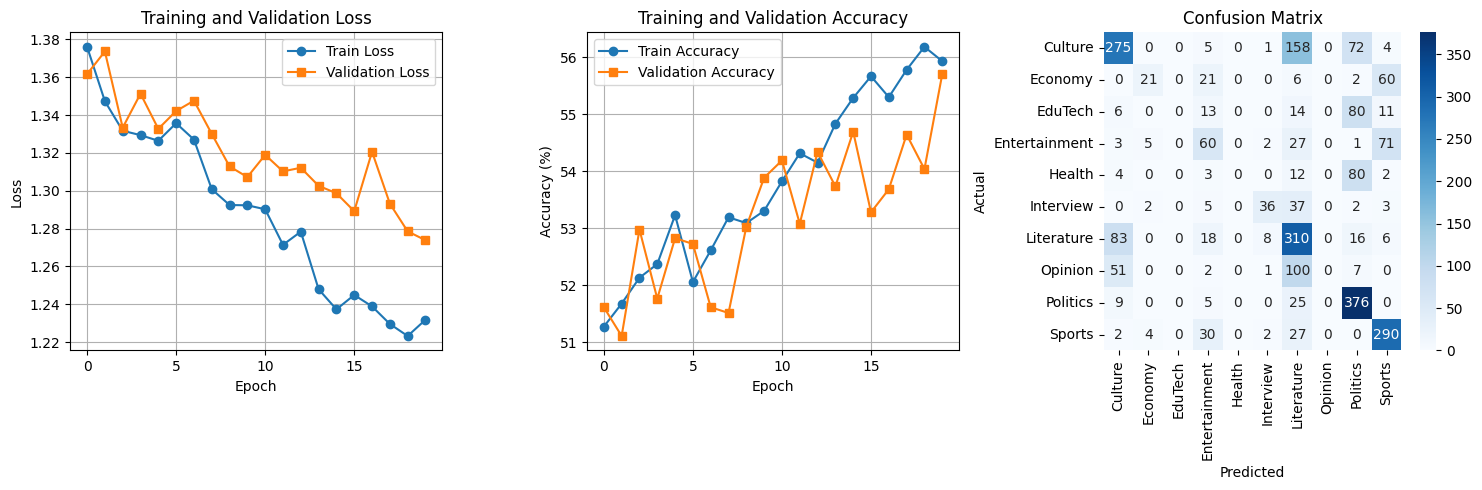

In [25]:
# Plot training curves
plt.figure(figsize=(15, 5))

# Loss curves
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='s')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy curves
plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(val_accuracies, label='Validation Accuracy', marker='s')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# Confusion Matrix
plt.subplot(1, 3, 3)
cm = confusion_matrix(test_targets, test_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()


# attention based

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)


class CharacterTokenizer:
    def __init__(self, max_length=200):
        self.char_to_idx = {}
        self.idx_to_char = {}
        self.max_length = max_length
        self.vocab_size = 0

    def fit(self, texts):
        # Get all unique characters
        all_chars = set()
        for text in texts:
            if pd.notna(text):  # Handle NaN values
                all_chars.update(text)

        # Create character mappings
        # Reserve 0 for padding, 1 for unknown
        self.char_to_idx = {'<PAD>': 0, '<UNK>': 1}
        self.idx_to_char = {0: '<PAD>', 1: '<UNK>'}

        for idx, char in enumerate(sorted(all_chars), 2):
            self.char_to_idx[char] = idx
            self.idx_to_char[idx] = char

        self.vocab_size = len(self.char_to_idx)
        print(f"Vocabulary size: {self.vocab_size}")

    def encode(self, text):
        if pd.isna(text):
            return [0] * self.max_length

        encoded = []
        for char in text[:self.max_length]:
            encoded.append(self.char_to_idx.get(char, 1))  # 1 for unknown

        # Pad or truncate to max_length
        if len(encoded) < self.max_length:
            encoded.extend([0] * (self.max_length - len(encoded)))
        else:
            encoded = encoded[:self.max_length]

        return encoded

    def encode_batch(self, texts):
        return [self.encode(text) for text in texts]

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoded_text = self.tokenizer.encode(text)

        return {
            'text': torch.tensor(encoded_text, dtype=torch.long),
            'label': torch.tensor(label, dtype=torch.long)
        }

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.d_k)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        attention_weights = torch.softmax(scores, dim=-1)
        output = torch.matmul(attention_weights, V)

        return output, attention_weights

    def forward(self, x, mask=None):
        batch_size, seq_len, d_model = x.size()

        Q = self.W_q(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)

        attention_output, attention_weights = self.scaled_dot_product_attention(Q, K, V, mask)

        attention_output = attention_output.transpose(1, 2).contiguous().view(
            batch_size, seq_len, d_model
        )

        output = self.W_o(attention_output)

        return output

class AttentionClassifier(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, num_classes, max_length, dropout=0.1):
        super(AttentionClassifier, self).__init__()
        self.d_model = d_model
        self.max_length = max_length

        # Character embedding
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)

        # Positional encoding
        self.pos_encoding = self.create_positional_encoding(max_length, d_model)

        # Multi-head attention
        self.attention = MultiHeadAttention(d_model, num_heads)

        # Feed forward network
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_model * 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model * 2, d_model)
        )

        # Layer normalization
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, num_classes)
        )

        self.dropout = nn.Dropout(dropout)

    def create_positional_encoding(self, max_length, d_model):
        pe = torch.zeros(max_length, d_model)
        position = torch.arange(0, max_length).unsqueeze(1).float()

        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                           -(np.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        return pe.unsqueeze(0)

    def forward(self, x):
        batch_size, seq_len = x.size()

        # Create padding mask
        mask = (x != 0).unsqueeze(1).unsqueeze(1)

        # Embedding and positional encoding
        embedded = self.embedding(x) * np.sqrt(self.d_model)
        embedded += self.pos_encoding[:, :seq_len, :].to(x.device)
        embedded = self.dropout(embedded)

        # Self-attention with residual connection
        attention_output = self.attention(embedded, mask)
        x1 = self.norm1(embedded + attention_output)

        # Feed forward with residual connection
        ffn_output = self.ffn(x1)
        x2 = self.norm2(x1 + ffn_output)

        # Global average pooling (ignoring padding tokens)
        mask_expanded = mask.squeeze(1).squeeze(1).unsqueeze(-1).float()
        pooled = (x2 * mask_expanded).sum(dim=1) / mask_expanded.sum(dim=1)

        # Classification
        output = self.classifier(pooled)

        return output

def train_model(model, train_loader, val_loader, num_epochs, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch in train_loader:
            texts = batch['text'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch in val_loader:
                texts = batch['text'].to(device)
                labels = batch['label'].to(device)

                outputs = model(texts)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        scheduler.step()

        # Calculate metrics
        train_loss_avg = train_loss / len(train_loader)
        val_loss_avg = val_loss / len(val_loader)
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total

        train_losses.append(train_loss_avg)
        val_losses.append(val_loss_avg)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss_avg:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss_avg:.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 50)

    return train_losses, val_losses, train_accuracies, val_accuracies



In [29]:
print(f"Dataset shape after removing NaN: {df.shape}")
print(f"Label distribution:\n{df['labels'].value_counts()}")

# Prepare data
texts = df['text'].tolist()
labels = df['labels'].tolist()

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)

print(f"Number of classes: {num_classes}")
print(f"Classes: {label_encoder.classes_}")

Dataset shape after removing NaN: (12376, 5)
Label distribution:
labels
Culture          2575
Literature       2207
Politics         2074
Sports           1774
Entertainment     844
Opinion           805
EduTech           619
Economy           549
Health            505
Interview         424
Name: count, dtype: int64
Number of classes: 10
Classes: ['Culture' 'Economy' 'EduTech' 'Entertainment' 'Health' 'Interview'
 'Literature' 'Opinion' 'Politics' 'Sports']


In [30]:
print(f"Dataset shape after removing NaN: {df.shape}")
print(f"Label distribution:\n{df['labels'].value_counts()}")

# Prepare data
texts = df['text'].tolist()
labels = df['labels'].tolist()

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)

print(f"Number of classes: {num_classes}")
print(f"Classes: {label_encoder.classes_}")

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    texts, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels
)

Dataset shape after removing NaN: (12376, 5)
Label distribution:
labels
Culture          2575
Literature       2207
Politics         2074
Sports           1774
Entertainment     844
Opinion           805
EduTech           619
Economy           549
Health            505
Interview         424
Name: count, dtype: int64
Number of classes: 10
Classes: ['Culture' 'Economy' 'EduTech' 'Entertainment' 'Health' 'Interview'
 'Literature' 'Opinion' 'Politics' 'Sports']


In [31]:
# Create and fit tokenizer
tokenizer = CharacterTokenizer(max_length=200)
tokenizer.fit(texts)

# Create datasets
train_dataset = TextDataset(X_train, y_train, tokenizer)
val_dataset = TextDataset(X_val, y_val, tokenizer)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Model parameters
d_model = 128
num_heads = 8
max_length = 200

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Vocabulary size: 269
Using device: cuda


In [32]:
model = AttentionClassifier(
        vocab_size=tokenizer.vocab_size,
        d_model=d_model,
        num_heads=num_heads,
        num_classes=num_classes,
        max_length=max_length,
        dropout=0.1
    ).to(device)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 175,818


In [41]:
# Train model
num_epochs = 30
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, num_epochs, device
)

Epoch [1/30]
Train Loss: 0.8933, Train Acc: 66.88%
Val Loss: 1.0188, Val Acc: 61.87%
--------------------------------------------------
Epoch [2/30]
Train Loss: 0.8957, Train Acc: 67.09%
Val Loss: 0.9640, Val Acc: 65.27%
--------------------------------------------------
Epoch [3/30]
Train Loss: 0.8948, Train Acc: 66.75%
Val Loss: 1.0071, Val Acc: 63.49%
--------------------------------------------------
Epoch [4/30]
Train Loss: 0.8878, Train Acc: 66.95%
Val Loss: 0.9594, Val Acc: 64.90%
--------------------------------------------------
Epoch [5/30]
Train Loss: 0.8845, Train Acc: 67.07%
Val Loss: 1.0172, Val Acc: 63.37%
--------------------------------------------------
Epoch [6/30]
Train Loss: 0.8839, Train Acc: 67.06%
Val Loss: 0.9949, Val Acc: 64.42%
--------------------------------------------------
Epoch [7/30]
Train Loss: 0.8725, Train Acc: 67.95%
Val Loss: 0.9724, Val Acc: 65.06%
--------------------------------------------------
Epoch [8/30]
Train Loss: 0.8682, Train Acc: 67.9

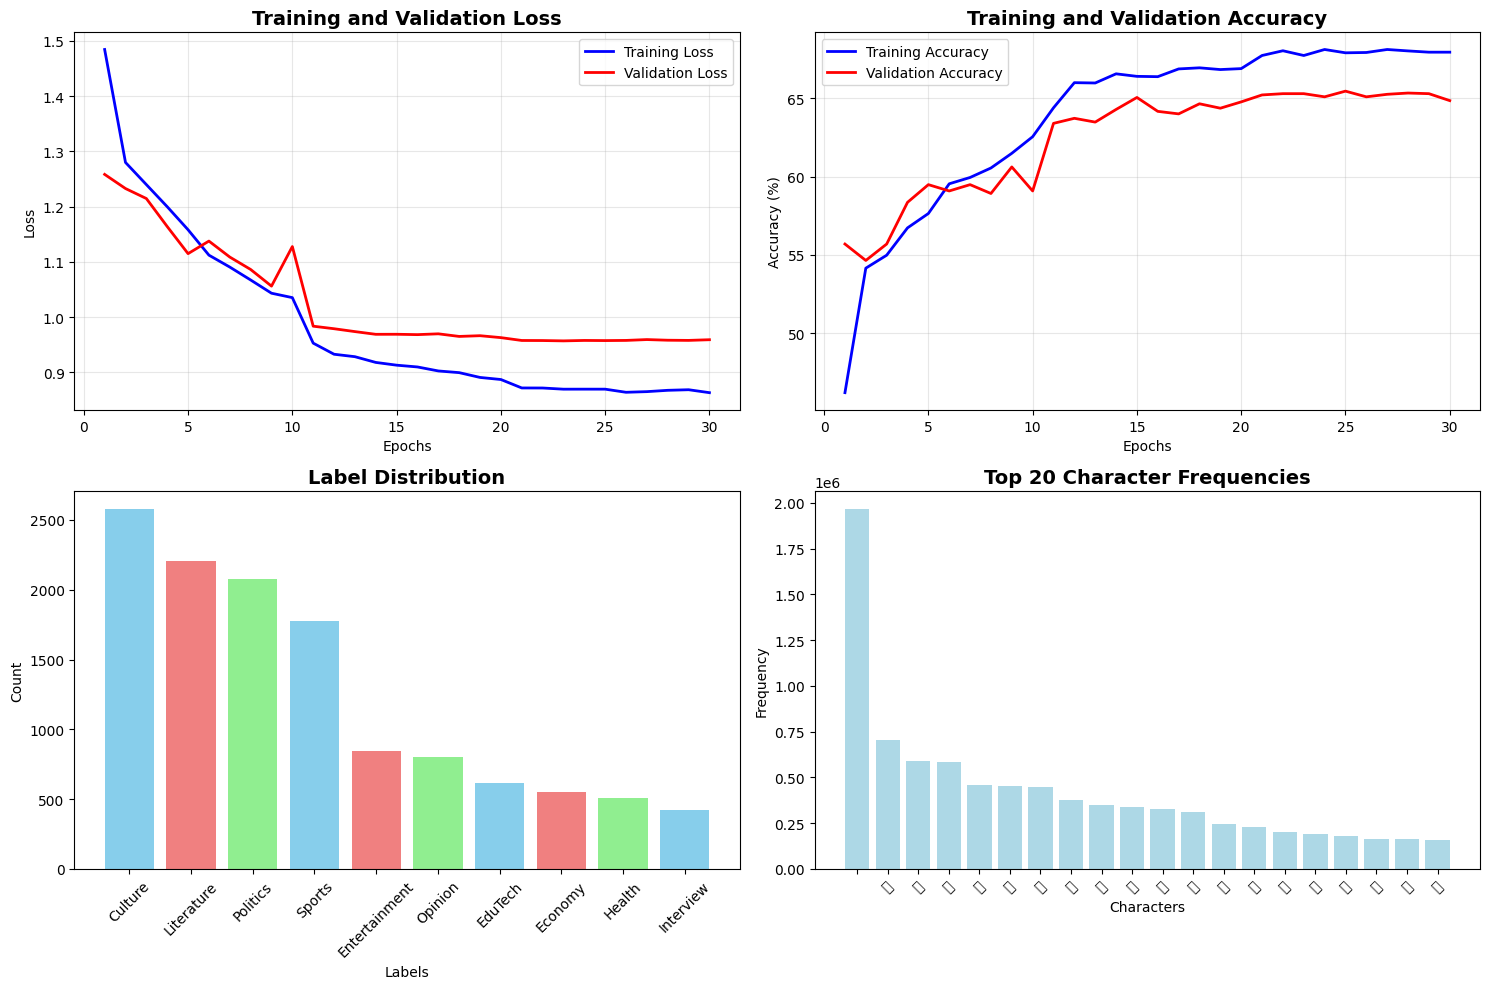

In [34]:
# Plot results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Loss plots
epochs = range(1, num_epochs + 1)
ax1.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
ax1.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plots
ax2.plot(epochs, train_accuracies, 'b-', label='Training Accuracy', linewidth=2)
ax2.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy', linewidth=2)
ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Label distribution
label_counts = df['labels'].value_counts()
ax3.bar(label_counts.index, label_counts.values, color=['skyblue', 'lightcoral', 'lightgreen'])
ax3.set_title('Label Distribution', fontsize=14, fontweight='bold')
ax3.set_xlabel('Labels')
ax3.set_ylabel('Count')
ax3.tick_params(axis='x', rotation=45)

# Character frequency (top 20)
all_text = ' '.join(texts)
char_freq = Counter(all_text)
top_chars = dict(char_freq.most_common(20))

ax4.bar(range(len(top_chars)), list(top_chars.values()), color='lightblue')
ax4.set_title('Top 20 Character Frequencies', fontsize=14, fontweight='bold')
ax4.set_xlabel('Characters')
ax4.set_ylabel('Frequency')
ax4.set_xticks(range(len(top_chars)))
ax4.set_xticklabels(list(top_chars.keys()), rotation=45)

plt.tight_layout()
plt.show()




In [43]:
# Final evaluation
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        texts = batch['text'].to(device)
        labels = batch['label'].to(device)

        outputs = model(texts)
        _, predicted = torch.max(outputs, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print classification report
print("\nClassification Report:")
print(classification_report(
    all_labels,
    all_predictions,
    target_names=label_encoder.classes_
))

print(f"\nFinal Validation Accuracy: {accuracy_score(all_labels, all_predictions):.4f}")



Classification Report:
               precision    recall  f1-score   support

      Culture       0.73      0.72      0.72       515
      Economy       0.51      0.37      0.43       110
      EduTech       0.42      0.17      0.24       124
Entertainment       0.48      0.41      0.44       169
       Health       0.54      0.28      0.37       101
    Interview       0.76      0.64      0.69        85
   Literature       0.69      0.73      0.71       441
      Opinion       0.78      0.67      0.72       161
     Politics       0.68      0.86      0.76       415
       Sports       0.64      0.80      0.71       355

     accuracy                           0.67      2476
    macro avg       0.62      0.56      0.58      2476
 weighted avg       0.66      0.67      0.65      2476


Final Validation Accuracy: 0.6684


In [44]:
# Example predictions
print("\nExample Predictions:")
model.eval()
sample_texts = [
    "भारतीय संस्कृति में मंदिरों का विशेष स्थान है",
    "नई फिल्म बहुत अच्छी है और मनोरंजक है",
    "शिक्षा तकनीक के साथ आगे बढ़ रही है"
]

with torch.no_grad():
    for text in sample_texts:
        encoded = torch.tensor(tokenizer.encode(text)).unsqueeze(0).to(device)
        output = model(encoded)
        prediction = torch.softmax(output, dim=1)
        predicted_class = label_encoder.classes_[torch.argmax(prediction).item()]
        confidence = torch.max(prediction).item()

        print(f"Text: {text}")
        print(f"Predicted: {predicted_class} (Confidence: {confidence:.3f})")
        print("-" * 60)


Example Predictions:
Text: भारतीय संस्कृति में मंदिरों का विशेष स्थान है
Predicted: Literature (Confidence: 0.962)
------------------------------------------------------------
Text: नई फिल्म बहुत अच्छी है और मनोरंजक है
Predicted: Literature (Confidence: 0.983)
------------------------------------------------------------
Text: शिक्षा तकनीक के साथ आगे बढ़ रही है
Predicted: Literature (Confidence: 0.977)
------------------------------------------------------------


# new byte lavel tokenizer

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)


class ByteLevelTokenizer:
    def __init__(self, max_length=200):
        self.byte_to_idx = {}
        self.idx_to_byte = {}
        self.max_length = max_length
        self.vocab_size = 0

    def fit(self, texts):
        # Get all unique bytes from UTF-8 encoded texts
        all_bytes = set()
        for text in texts:
            if pd.notna(text):  # Handle NaN values
                # Convert text to UTF-8 bytes
                utf8_bytes = text.encode('utf-8')
                all_bytes.update(utf8_bytes)

        # Create byte mappings
        # Reserve 0 for padding, 1 for unknown
        self.byte_to_idx = {'<PAD>': 0, '<UNK>': 1}
        self.idx_to_byte = {0: '<PAD>', 1: '<UNK>'}

        # Map all possible byte values (0-255) for completeness
        for byte_val in range(256):
            if byte_val in all_bytes:
                idx = len(self.byte_to_idx)
                self.byte_to_idx[byte_val] = idx
                self.idx_to_byte[idx] = byte_val

        self.vocab_size = len(self.byte_to_idx)
        print(f"Vocabulary size (byte-level): {self.vocab_size}")
        print(f"Unique bytes found: {len(all_bytes)}")

    def encode(self, text):
        if pd.isna(text):
            return [0] * self.max_length

        # Convert text to UTF-8 bytes
        try:
            utf8_bytes = text.encode('utf-8')
        except Exception:
            return [0] * self.max_length

        encoded = []
        for byte_val in utf8_bytes[:self.max_length]:
            encoded.append(self.byte_to_idx.get(byte_val, 1))  # 1 for unknown

        # Pad or truncate to max_length
        if len(encoded) < self.max_length:
            encoded.extend([0] * (self.max_length - len(encoded)))
        else:
            encoded = encoded[:self.max_length]

        return encoded

    def decode(self, indices):
        """Decode byte indices back to text"""
        bytes_list = []
        for idx in indices:
            if idx == 0:  # Padding
                break
            elif idx == 1:  # Unknown
                continue
            else:
                byte_val = self.idx_to_byte.get(idx)
                if byte_val is not None and isinstance(byte_val, int):
                    bytes_list.append(byte_val)

        try:
            return bytes(bytes_list).decode('utf-8', errors='ignore')
        except Exception:
            return ""

    def encode_batch(self, texts):
        return [self.encode(text) for text in texts]

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoded_text = self.tokenizer.encode(text)

        return {
            'text': torch.tensor(encoded_text, dtype=torch.long),
            'label': torch.tensor(label, dtype=torch.long)
        }

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.d_k)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        attention_weights = torch.softmax(scores, dim=-1)
        output = torch.matmul(attention_weights, V)

        return output, attention_weights

    def forward(self, x, mask=None):
        batch_size, seq_len, d_model = x.size()

        Q = self.W_q(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)

        attention_output, attention_weights = self.scaled_dot_product_attention(Q, K, V, mask)

        attention_output = attention_output.transpose(1, 2).contiguous().view(
            batch_size, seq_len, d_model
        )

        output = self.W_o(attention_output)

        return output

class AttentionClassifier(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, num_classes, max_length, dropout=0.1):
        super(AttentionClassifier, self).__init__()
        self.d_model = d_model
        self.max_length = max_length

        # Byte embedding (increased embedding dimension for better byte representation)
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)

        # Positional encoding
        self.pos_encoding = self.create_positional_encoding(max_length, d_model)

        # Multi-head attention layers (stacked for better representation)
        self.attention1 = MultiHeadAttention(d_model, num_heads)
        self.attention2 = MultiHeadAttention(d_model, num_heads)

        # Feed forward networks
        self.ffn1 = nn.Sequential(
            nn.Linear(d_model, d_model * 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model * 2, d_model)
        )

        self.ffn2 = nn.Sequential(
            nn.Linear(d_model, d_model * 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model * 2, d_model)
        )

        # Layer normalization
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.norm4 = nn.LayerNorm(d_model)

        # Classification head with more capacity for byte-level features
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, num_classes)
        )

        self.dropout = nn.Dropout(dropout)

    def create_positional_encoding(self, max_length, d_model):
        pe = torch.zeros(max_length, d_model)
        position = torch.arange(0, max_length).unsqueeze(1).float()

        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                           -(np.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        return pe.unsqueeze(0)

    def forward(self, x):
        batch_size, seq_len = x.size()

        # Create padding mask
        mask = (x != 0).unsqueeze(1).unsqueeze(1)

        # Embedding and positional encoding
        embedded = self.embedding(x) * np.sqrt(self.d_model)
        embedded += self.pos_encoding[:, :seq_len, :].to(x.device)
        embedded = self.dropout(embedded)

        # First attention layer with residual connection
        attention_output1 = self.attention1(embedded, mask)
        x1 = self.norm1(embedded + attention_output1)

        # First feed forward with residual connection
        ffn_output1 = self.ffn1(x1)
        x2 = self.norm2(x1 + ffn_output1)

        # Second attention layer with residual connection
        attention_output2 = self.attention2(x2, mask)
        x3 = self.norm3(x2 + attention_output2)

        # Second feed forward with residual connection
        ffn_output2 = self.ffn2(x3)
        x4 = self.norm4(x3 + ffn_output2)

        # Global average pooling (ignoring padding tokens)
        mask_expanded = mask.squeeze(1).squeeze(1).unsqueeze(-1).float()
        pooled = (x4 * mask_expanded).sum(dim=1) / mask_expanded.sum(dim=1)

        # Classification
        output = self.classifier(pooled)

        return output

def train_model(model, train_loader, val_loader, num_epochs, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch in train_loader:
            texts = batch['text'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch in val_loader:
                texts = batch['text'].to(device)
                labels = batch['label'].to(device)

                outputs = model(texts)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        scheduler.step()

        # Calculate metrics
        train_loss_avg = train_loss / len(train_loader)
        val_loss_avg = val_loss / len(val_loader)
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total

        train_losses.append(train_loss_avg)
        val_losses.append(val_loss_avg)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss_avg:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss_avg:.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 50)

    return train_losses, val_losses, train_accuracies, val_accuracies



Dataset shape after removing NaN: (12376, 5)
Label distribution:
labels
Culture          2575
Literature       2207
Politics         2074
Sports           1774
Entertainment     844
Opinion           805
EduTech           619
Economy           549
Health            505
Interview         424
Name: count, dtype: int64
Number of classes: 10
Classes: ['Culture' 'Economy' 'EduTech' 'Entertainment' 'Health' 'Interview'
 'Literature' 'Opinion' 'Politics' 'Sports']
Vocabulary size (byte-level): 162
Unique bytes found: 160
Using device: cuda
Model parameters: 311,114
Epoch [1/30]
Train Loss: 1.8951, Train Acc: 30.31%
Val Loss: 1.9028, Val Acc: 27.91%
--------------------------------------------------
Epoch [2/30]
Train Loss: 1.7772, Train Acc: 35.34%
Val Loss: 1.7083, Val Acc: 37.72%
--------------------------------------------------
Epoch [3/30]
Train Loss: 1.7227, Train Acc: 38.03%
Val Loss: 1.7106, Val Acc: 38.45%
--------------------------------------------------
Epoch [4/30]
Train Loss: 1.

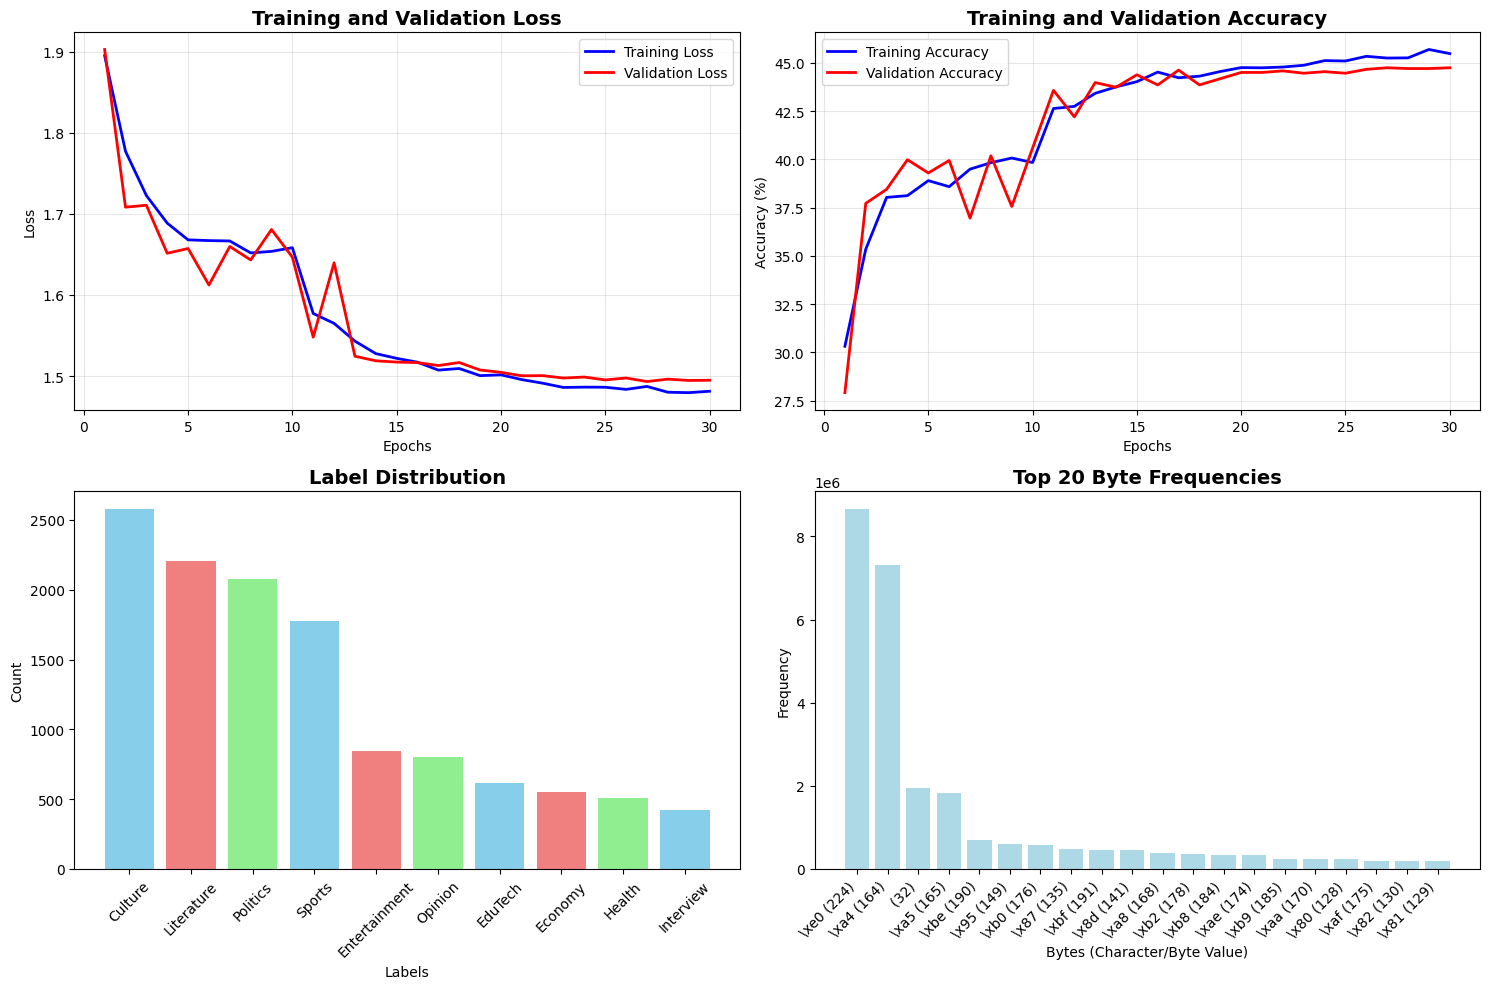


Classification Report:
               precision    recall  f1-score   support

      Culture       0.67      0.48      0.56       515
      Economy       0.00      0.00      0.00       110
      EduTech       0.00      0.00      0.00       124
Entertainment       0.04      0.01      0.01       169
       Health       0.00      0.00      0.00       101
    Interview       0.00      0.00      0.00        85
   Literature       0.41      0.56      0.47       441
      Opinion       0.45      0.14      0.22       161
     Politics       0.38      0.75      0.51       415
       Sports       0.46      0.78      0.58       355

     accuracy                           0.45      2476
    macro avg       0.24      0.27      0.23      2476
 weighted avg       0.37      0.45      0.38      2476


Final Validation Accuracy: 0.4475

Example Predictions:
Text: भारतीय संस्कृति में मंदिरों का विशेष स्थान है
Byte length: 121, Character length: 45
Predicted: Literature (Confidence: 0.265)
Decoded: भारत

In [46]:

print(f"Dataset shape after removing NaN: {df.shape}")
print(f"Label distribution:\n{df['labels'].value_counts()}")

# Prepare data
texts = df['text'].tolist()
labels = df['labels'].tolist()

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)

print(f"Number of classes: {num_classes}")
print(f"Classes: {label_encoder.classes_}")

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    texts, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels
)

# Create and fit tokenizer
tokenizer = ByteLevelTokenizer(max_length=200)
tokenizer.fit(texts)

# Create datasets
train_dataset = TextDataset(X_train, y_train, tokenizer)
val_dataset = TextDataset(X_val, y_val, tokenizer)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Model parameters
d_model = 128
num_heads = 8
max_length = 200

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = AttentionClassifier(
    vocab_size=tokenizer.vocab_size,
    d_model=d_model,
    num_heads=num_heads,
    num_classes=num_classes,
    max_length=max_length,
    dropout=0.1
).to(device)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Train model
num_epochs = 30
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, num_epochs, device
)

# Plot results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Loss plots
epochs = range(1, num_epochs + 1)
ax1.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
ax1.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plots
ax2.plot(epochs, train_accuracies, 'b-', label='Training Accuracy', linewidth=2)
ax2.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy', linewidth=2)
ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Label distribution
label_counts = df['labels'].value_counts()
ax3.bar(label_counts.index, label_counts.values, color=['skyblue', 'lightcoral', 'lightgreen'])
ax3.set_title('Label Distribution', fontsize=14, fontweight='bold')
ax3.set_xlabel('Labels')
ax3.set_ylabel('Count')
ax3.tick_params(axis='x', rotation=45)

# Byte frequency analysis (top 20 most common bytes)
all_text = ' '.join(texts)
byte_freq = Counter()

for text in texts:
    if pd.notna(text):
        utf8_bytes = text.encode('utf-8')
        byte_freq.update(utf8_bytes)

top_bytes = dict(byte_freq.most_common(20))

# Convert byte values to readable format for display
byte_labels = []
byte_values = []
for byte_val, freq in top_bytes.items():
    try:
        # Try to decode single byte to character for display
        char_repr = chr(byte_val) if 32 <= byte_val <= 126 else f'\\x{byte_val:02x}'
        byte_labels.append(f'{char_repr} ({byte_val})')
    except:
        byte_labels.append(f'\\x{byte_val:02x}')
    byte_values.append(freq)

ax4.bar(range(len(byte_values)), byte_values, color='lightblue')
ax4.set_title('Top 20 Byte Frequencies', fontsize=14, fontweight='bold')
ax4.set_xlabel('Bytes (Character/Byte Value)')
ax4.set_ylabel('Frequency')
ax4.set_xticks(range(len(byte_labels)))
ax4.set_xticklabels(byte_labels, rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Final evaluation
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        texts = batch['text'].to(device)
        labels = batch['label'].to(device)

        outputs = model(texts)
        _, predicted = torch.max(outputs, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print classification report
print("\nClassification Report:")
print(classification_report(
    all_labels,
    all_predictions,
    target_names=label_encoder.classes_
))

print(f"\nFinal Validation Accuracy: {accuracy_score(all_labels, all_predictions):.4f}")

# Example predictions with byte-level decoding
print("\nExample Predictions:")
model.eval()
sample_texts = [
    "भारतीय संस्कृति में मंदिरों का विशेष स्थान है",
    "नई फिल्म बहुत अच्छी है और मनोरंजक है",
    "शिक्षा तकनीक के साथ आगे बढ़ रही है"
]

with torch.no_grad():
    for text in sample_texts:
        encoded = torch.tensor(tokenizer.encode(text)).unsqueeze(0).to(device)
        output = model(encoded)
        prediction = torch.softmax(output, dim=1)
        predicted_class = label_encoder.classes_[torch.argmax(prediction).item()]
        confidence = torch.max(prediction).item()

        # Show byte-level encoding info
        byte_length = len(text.encode('utf-8'))
        char_length = len(text)

        print(f"Text: {text}")
        print(f"Byte length: {byte_length}, Character length: {char_length}")
        print(f"Predicted: {predicted_class} (Confidence: {confidence:.3f})")

        # Show decoded text to verify encoding/decoding
        decoded_text = tokenizer.decode(tokenizer.encode(text))
        print(f"Decoded: {decoded_text}")
        print("-" * 60)

# words level tokenizer

In [50]:
! pip install -q scikit-learn

In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
from collections import Counter, defaultdict
import re
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)


class WordPieceTokenizer:
    def __init__(self, vocab_size=1000, max_length=200, unk_token='[UNK]', pad_token='[PAD]',
                 cls_token='[CLS]', sep_token='[SEP]'):
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.unk_token = unk_token
        self.pad_token = pad_token
        self.cls_token = cls_token
        self.sep_token = sep_token

        # Special tokens
        self.special_tokens = [pad_token, unk_token, cls_token, sep_token]

        # Vocabulary mappings
        self.token_to_id = {}
        self.id_to_token = {}
        self.vocab = set()

    def _get_word_tokens(self, texts):
        """Extract all words and characters from texts"""
        word_freq = Counter()
        char_freq = Counter()

        for text in texts:
            if pd.notna(text):
                # Basic tokenization - split by whitespace and punctuation
                words = re.findall(r'\w+|[^\w\s]', text.lower())
                for word in words:
                    word_freq[word] += 1
                    for char in word:
                        char_freq[char] += 1

        return word_freq, char_freq

    def _build_wordpiece_vocab(self, word_freq, char_freq):
        """Build WordPiece vocabulary using BPE-like algorithm"""
        # Start with special tokens
        vocab = set(self.special_tokens)

        # Add individual characters
        for char in char_freq:
            vocab.add(char)

        # Add frequent words
        frequent_words = [word for word, freq in word_freq.most_common(100) if len(word) > 1]
        vocab.update(frequent_words)

        # Generate subword pieces
        subword_freq = Counter()

        for word, freq in word_freq.items():
            if len(word) > 2:
                # Generate all possible substrings of length 2-4
                for i in range(len(word)):
                    for j in range(i + 2, min(i + 5, len(word) + 1)):
                        subword = word[i:j]
                        if i > 0:  # Add ## prefix for continuation pieces
                            subword = '##' + subword
                        subword_freq[subword] += freq

        # Add most frequent subwords
        top_subwords = [sw for sw, freq in subword_freq.most_common(self.vocab_size - len(vocab))]
        vocab.update(top_subwords)

        return list(vocab)[:self.vocab_size]

    def fit(self, texts):
        """Fit the tokenizer on the given texts"""
        print("Building WordPiece vocabulary...")

        # Get word and character frequencies
        word_freq, char_freq = self._get_word_tokens(texts)

        # Build vocabulary
        vocab_list = self._build_wordpiece_vocab(word_freq, char_freq)

        # Create mappings
        self.token_to_id = {token: idx for idx, token in enumerate(vocab_list)}
        self.id_to_token = {idx: token for idx, token in enumerate(vocab_list)}
        self.vocab = set(vocab_list)

        print(f"Vocabulary size: {len(self.vocab)}")
        print(f"Sample tokens: {list(self.vocab)[:10]}")

    def _tokenize_word(self, word):
        """Tokenize a single word using WordPiece algorithm"""
        if word in self.vocab:
            return [word]

        tokens = []
        start = 0

        while start < len(word):
            end = len(word)
            cur_substr = None

            # Find the longest matching substring
            while start < end:
                substr = word[start:end]
                if start > 0:
                    substr = '##' + substr

                if substr in self.vocab:
                    cur_substr = substr
                    break
                end -= 1

            if cur_substr is None:
                # If no match found, use unknown token
                tokens.append(self.unk_token)
                start += 1
            else:
                tokens.append(cur_substr)
                start = end

        return tokens

    def tokenize(self, text):
        """Tokenize text into WordPiece tokens"""
        if pd.isna(text):
            return []

        # Basic word tokenization
        words = re.findall(r'\w+|[^\w\s]', text.lower())

        tokens = [self.cls_token]  # Start with CLS token

        for word in words:
            word_tokens = self._tokenize_word(word)
            tokens.extend(word_tokens)

        tokens.append(self.sep_token)  # End with SEP token

        return tokens

    def encode(self, text):
        """Encode text to token IDs"""
        tokens = self.tokenize(text)

        # Convert tokens to IDs
        token_ids = []
        for token in tokens:
            token_ids.append(self.token_to_id.get(token, self.token_to_id[self.unk_token]))

        # Pad or truncate to max_length
        if len(token_ids) < self.max_length:
            token_ids.extend([self.token_to_id[self.pad_token]] * (self.max_length - len(token_ids)))
        else:
            token_ids = token_ids[:self.max_length]
            # Ensure the last token is SEP
            if token_ids[-1] != self.token_to_id[self.sep_token]:
                token_ids[-1] = self.token_to_id[self.sep_token]

        return token_ids

    def decode(self, token_ids):
        """Decode token IDs back to text"""
        tokens = []
        for token_id in token_ids:
            if token_id == self.token_to_id[self.pad_token]:
                break
            tokens.append(self.id_to_token.get(token_id, self.unk_token))

        # Combine WordPiece tokens back to words
        text_tokens = []
        current_word = ""

        for token in tokens:
            if token in self.special_tokens:
                if current_word:
                    text_tokens.append(current_word)
                    current_word = ""
                if token not in [self.cls_token, self.sep_token, self.pad_token]:
                    text_tokens.append(token)
            elif token.startswith('##'):
                current_word += token[2:]  # Remove ## prefix
            else:
                if current_word:
                    text_tokens.append(current_word)
                current_word = token

        if current_word:
            text_tokens.append(current_word)

        return ' '.join(text_tokens)

    def encode_batch(self, texts):
        return [self.encode(text) for text in texts]

    def get_vocab_size(self):
        return len(self.vocab)

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoded_text = self.tokenizer.encode(text)

        return {
            'text': torch.tensor(encoded_text, dtype=torch.long),
            'label': torch.tensor(label, dtype=torch.long)
        }

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.d_k)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        attention_weights = torch.softmax(scores, dim=-1)
        output = torch.matmul(attention_weights, V)

        return output, attention_weights

    def forward(self, x, mask=None):
        batch_size, seq_len, d_model = x.size()

        Q = self.W_q(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)

        attention_output, attention_weights = self.scaled_dot_product_attention(Q, K, V, mask)

        attention_output = attention_output.transpose(1, 2).contiguous().view(
            batch_size, seq_len, d_model
        )

        output = self.W_o(attention_output)

        return output

class AttentionClassifier(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, num_classes, max_length, dropout=0.1):
        super(AttentionClassifier, self).__init__()
        self.d_model = d_model
        self.max_length = max_length

        # WordPiece token embedding
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)

        # Positional encoding
        self.pos_encoding = self.create_positional_encoding(max_length, d_model)

        # Multi-head attention layers (transformer-like architecture)
        self.attention1 = MultiHeadAttention(d_model, num_heads)
        self.attention2 = MultiHeadAttention(d_model, num_heads)
        self.attention3 = MultiHeadAttention(d_model, num_heads)

        # Feed forward networks
        self.ffn1 = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.GELU(),  # GELU activation like BERT
            nn.Dropout(dropout),
            nn.Linear(d_model * 4, d_model)
        )

        self.ffn2 = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model * 4, d_model)
        )

        self.ffn3 = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model * 4, d_model)
        )

        # Layer normalization
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.norm4 = nn.LayerNorm(d_model)
        self.norm5 = nn.LayerNorm(d_model)
        self.norm6 = nn.LayerNorm(d_model)

        # Classification head (uses CLS token representation)
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.Tanh(),  # Tanh activation like BERT
            nn.Dropout(dropout),
            nn.Linear(d_model, num_classes)
        )

        self.dropout = nn.Dropout(dropout)

    def create_positional_encoding(self, max_length, d_model):
        pe = torch.zeros(max_length, d_model)
        position = torch.arange(0, max_length).unsqueeze(1).float()

        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                           -(np.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        return pe.unsqueeze(0)

    def forward(self, x):
        batch_size, seq_len = x.size()

        # Create attention mask (1 for real tokens, 0 for padding)
        attention_mask = (x != 0).float()
        mask = attention_mask.unsqueeze(1).unsqueeze(1)

        # Token embedding + positional encoding
        embedded = self.embedding(x)
        embedded += self.pos_encoding[:, :seq_len, :].to(x.device)
        embedded = self.dropout(embedded)

        # First transformer layer
        attention_output1 = self.attention1(embedded, mask)
        x1 = self.norm1(embedded + self.dropout(attention_output1))

        ffn_output1 = self.ffn1(x1)
        x2 = self.norm2(x1 + self.dropout(ffn_output1))

        # Second transformer layer
        attention_output2 = self.attention2(x2, mask)
        x3 = self.norm3(x2 + self.dropout(attention_output2))

        ffn_output2 = self.ffn2(x3)
        x4 = self.norm4(x3 + self.dropout(ffn_output2))

        # Third transformer layer
        attention_output3 = self.attention3(x4, mask)
        x5 = self.norm5(x4 + self.dropout(attention_output3))

        ffn_output3 = self.ffn3(x5)
        x6 = self.norm6(x5 + self.dropout(ffn_output3))

        # Use CLS token representation for classification (first token)
        cls_representation = x6[:, 0, :]  # Take the first token ([CLS])

        # Classification
        output = self.classifier(cls_representation)

        return output

def train_model(model, train_loader, val_loader, num_epochs, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch in train_loader:
            texts = batch['text'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch in val_loader:
                texts = batch['text'].to(device)
                labels = batch['label'].to(device)

                outputs = model(texts)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        scheduler.step()

        # Calculate metrics
        train_loss_avg = train_loss / len(train_loader)
        val_loss_avg = val_loss / len(val_loader)
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total

        train_losses.append(train_loss_avg)
        val_losses.append(val_loss_avg)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss_avg:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss_avg:.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 50)

    return train_losses, val_losses, train_accuracies, val_accuracies



In [55]:

print(f"Dataset shape after removing NaN: {df.shape}")
print(f"Label distribution:\n{df['labels'].value_counts()}")

# Prepare data
texts = df['text'].tolist()
labels = df['labels'].tolist()

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)

print(f"Number of classes: {num_classes}")
print(f"Classes: {label_encoder.classes_}")

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    texts, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels
)

# Create and fit tokenizer
tokenizer = WordPieceTokenizer(vocab_size=1000, max_length=128)
tokenizer.fit(texts)

# Create datasets
train_dataset = TextDataset(X_train, y_train, tokenizer)
val_dataset = TextDataset(X_val, y_val, tokenizer)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Model parameters
d_model = 256  # Increased for better WordPiece representation
num_heads = 8
max_length = 128

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = AttentionClassifier(
    vocab_size=tokenizer.get_vocab_size(),
    d_model=d_model,
    num_heads=num_heads,
    num_classes=num_classes,
    max_length=max_length,
    dropout=0.1
).to(device)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")



Dataset shape after removing NaN: (12376, 5)
Label distribution:
labels
Culture          2575
Literature       2207
Politics         2074
Sports           1774
Entertainment     844
Opinion           805
EduTech           619
Economy           549
Health            505
Interview         424
Name: count, dtype: int64
Number of classes: 10
Classes: ['Culture' 'Economy' 'EduTech' 'Entertainment' 'Health' 'Interview'
 'Literature' 'Opinion' 'Politics' 'Sports']
Building WordPiece vocabulary...
Vocabulary size: 964
Sample tokens: ['–', '##गम', 'एय', '##धर', '##हलक', '🙂', '🙁', 'l', 'j', 'ि']
Using device: cuda
Model parameters: 2,684,426


Epoch [1/30]
Train Loss: 2.1162, Train Acc: 20.26%
Val Loss: 2.1129, Val Acc: 20.80%
--------------------------------------------------
Epoch [2/30]
Train Loss: 2.1140, Train Acc: 20.36%
Val Loss: 2.1138, Val Acc: 20.80%
--------------------------------------------------
Epoch [3/30]
Train Loss: 2.1145, Train Acc: 20.03%
Val Loss: 2.1112, Val Acc: 20.80%
--------------------------------------------------
Epoch [4/30]
Train Loss: 2.1137, Train Acc: 20.47%
Val Loss: 2.1165, Val Acc: 20.80%
--------------------------------------------------
Epoch [5/30]
Train Loss: 2.1134, Train Acc: 20.47%
Val Loss: 2.1107, Val Acc: 20.80%
--------------------------------------------------
Epoch [6/30]
Train Loss: 2.1126, Train Acc: 20.35%
Val Loss: 2.1138, Val Acc: 20.80%
--------------------------------------------------
Epoch [7/30]
Train Loss: 2.1127, Train Acc: 20.15%
Val Loss: 2.1136, Val Acc: 17.81%
--------------------------------------------------
Epoch [8/30]
Train Loss: 2.1122, Train Acc: 20.0

AttributeError: 'Tensor' object has no attribute 'lower'

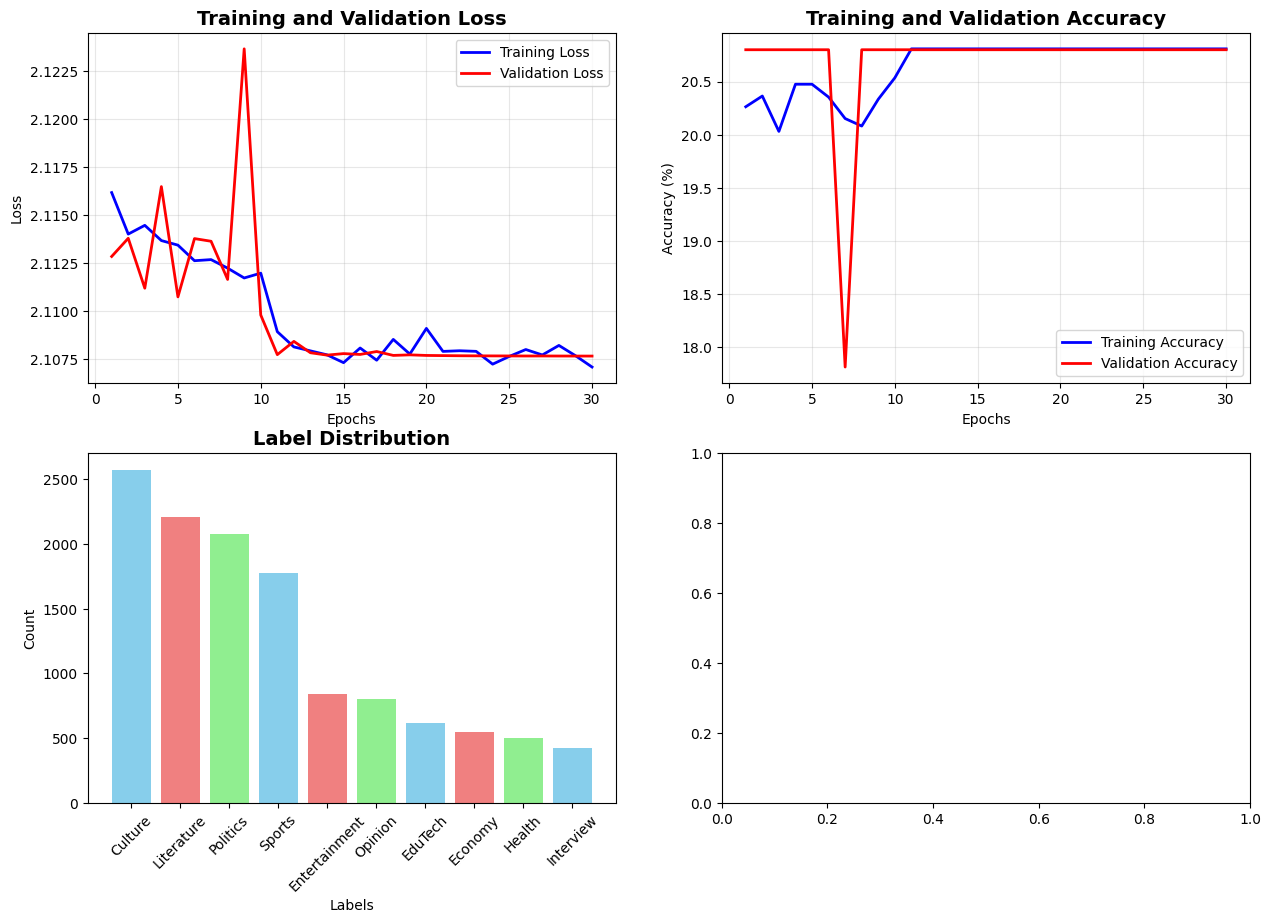

In [54]:
# Train model
num_epochs = 30
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, num_epochs, device
)

# Plot results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Loss plots
epochs = range(1, num_epochs + 1)
ax1.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
ax1.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plots
ax2.plot(epochs, train_accuracies, 'b-', label='Training Accuracy', linewidth=2)
ax2.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy', linewidth=2)
ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Label distribution
label_counts = df['labels'].value_counts()
ax3.bar(label_counts.index, label_counts.values, color=['skyblue', 'lightcoral', 'lightgreen'])
ax3.set_title('Label Distribution', fontsize=14, fontweight='bold')
ax3.set_xlabel('Labels')
ax3.set_ylabel('Count')
ax3.tick_params(axis='x', rotation=45)

# WordPiece token frequency analysis
all_tokens = []
for text in texts:
    if pd.notna(text):
        tokens = tokenizer.tokenize(text)
        all_tokens.extend(tokens)

token_freq = Counter(all_tokens)
top_tokens = dict(token_freq.most_common(20))

# Filter out special tokens for better visualization
display_tokens = {k: v for k, v in top_tokens.items()
                  if k not in tokenizer.special_tokens}

if len(display_tokens) < 20:
    display_tokens = top_tokens

token_names = list(display_tokens.keys())[:15]  # Show top 15 for readability
token_counts = list(display_tokens.values())[:15]

ax4.bar(range(len(token_counts)), token_counts, color='lightgreen')
ax4.set_title('Top 15 WordPiece Token Frequencies', fontsize=14, fontweight='bold')
ax4.set_xlabel('Tokens')
ax4.set_ylabel('Frequency')
ax4.set_xticks(range(len(token_names)))
ax4.set_xticklabels(token_names, rotation=45, ha='right')

plt.tight_layout()
plt.show()



In [56]:
# Final evaluation
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        texts = batch['text'].to(device)
        labels = batch['label'].to(device)

        outputs = model(texts)
        _, predicted = torch.max(outputs, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print classification report
print("\nClassification Report:")
print(classification_report(
    all_labels,
    all_predictions,
    target_names=label_encoder.classes_
))

print(f"\nFinal Validation Accuracy: {accuracy_score(all_labels, all_predictions):.4f}")

# Example predictions with WordPiece tokenization
print("\nExample Predictions:")
model.eval()
sample_texts = [
    "भारतीय संस्कृति में मंदिरों का विशेष स्थान है",
    "नई फिल्म बहुत अच्छी है और मनोरंजक है",
    "शिक्षा तकनीक के साथ आगे बढ़ रही है"
]

with torch.no_grad():
    for text in sample_texts:
        # Show tokenization process
        tokens = tokenizer.tokenize(text)
        encoded = torch.tensor(tokenizer.encode(text)).unsqueeze(0).to(device)
        output = model(encoded)
        prediction = torch.softmax(output, dim=1)
        predicted_class = label_encoder.classes_[torch.argmax(prediction).item()]
        confidence = torch.max(prediction).item()

        print(f"Text: {text}")
        print(f"Tokens: {tokens[:10]}...")  # Show first 10 tokens
        print(f"Number of tokens: {len(tokens)}")
        print(f"Predicted: {predicted_class} (Confidence: {confidence:.3f})")

        # Show decoded text to verify tokenization
        decoded_text = tokenizer.decode(tokenizer.encode(text))
        print(f"Decoded: {decoded_text}")
        print("-" * 80)


Classification Report:
               precision    recall  f1-score   support

      Culture       0.00      0.00      0.00       515
      Economy       0.00      0.00      0.00       110
      EduTech       0.00      0.00      0.00       124
Entertainment       0.00      0.01      0.00       169
       Health       0.00      0.00      0.00       101
    Interview       0.00      0.00      0.00        85
   Literature       0.00      0.00      0.00       441
      Opinion       0.00      0.00      0.00       161
     Politics       0.00      0.00      0.00       415
       Sports       0.16      1.00      0.28       355

     accuracy                           0.14      2476
    macro avg       0.02      0.10      0.03      2476
 weighted avg       0.02      0.14      0.04      2476


Final Validation Accuracy: 0.1434

Example Predictions:
Text: भारतीय संस्कृति में मंदिरों का विशेष स्थान है
Tokens: ['[CLS]', 'भ', 'ा', 'रत', 'ी', 'य', 'स', 'ं', 'स', '्']...
Number of tokens: 39
Predic